In [108]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

# Load the dataset
data = pd.read_csv('/content/NIFTY_historical_data.csv')

In [109]:
# Step 1: Data Cleaning
# Remove metadata rows and rename columns
data_cleaned = data.iloc[2:].copy()
data_cleaned.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']

# Convert data types
data_cleaned['Date'] = pd.to_datetime(data_cleaned['Date'], format='%d-%m-%Y', errors='coerce')
for col in ['Close', 'High', 'Low', 'Open', 'Volume']:
    data_cleaned[col] = pd.to_numeric(data_cleaned[col], errors='coerce')

# Drop rows where 'Date' is NaT
data_cleaned.dropna(subset=['Date'], inplace=True)

# Handle missing values using forward fill
data_cleaned.fillna(method='ffill', inplace=True)

<ipython-input-109-c41ec71b0186>:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_cleaned.fillna(method='ffill', inplace=True)


In [110]:
# Step 2: Feature Engineering
# Moving Averages
data_cleaned['MA_20'] = data_cleaned['Close'].rolling(window=20).mean()
data_cleaned['MA_50'] = data_cleaned['Close'].rolling(window=50).mean()

# Relative Strength Index (RSI)
delta = data_cleaned['Close'].diff()
gain = delta.where(delta > 0, 0).rolling(window=14).mean()
loss = -delta.where(delta < 0, 0).rolling(window=14).mean()
rs = gain / loss
data_cleaned['RSI'] = 100 - (100 / (1 + rs))

# Moving Average Convergence Divergence (MACD)
ema_12 = data_cleaned['Close'].ewm(span=12, adjust=False).mean()
ema_26 = data_cleaned['Close'].ewm(span=26, adjust=False).mean()
data_cleaned['MACD'] = ema_12 - ema_26
data_cleaned['Signal_Line'] = data_cleaned['MACD'].ewm(span=9, adjust=False).mean()

# Create target variable: 1 if the price goes up, 0 if it goes down
data_cleaned['Target'] = (data_cleaned['Close'].shift(-1) > data_cleaned['Close']).astype(int)

# Drop rows with NaN in target variable
data_cleaned.dropna(subset=['Target'], inplace=True)

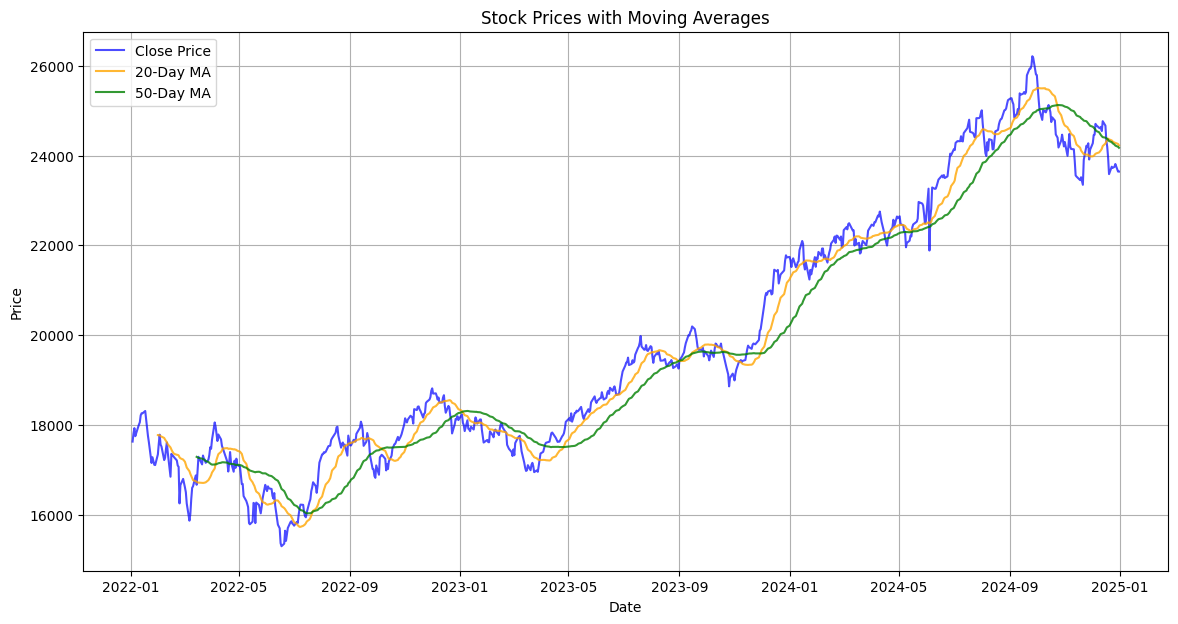

In [111]:
# Step 3: Data Visualization
# Plot stock prices with Moving Averages
plt.figure(figsize=(14, 7))
plt.plot(data_cleaned['Date'], data_cleaned['Close'], label='Close Price', color='blue', alpha=0.7)
plt.plot(data_cleaned['Date'], data_cleaned['MA_20'], label='20-Day MA', color='orange', alpha=0.8)
plt.plot(data_cleaned['Date'], data_cleaned['MA_50'], label='50-Day MA', color='green', alpha=0.8)
plt.title('Stock Prices with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()




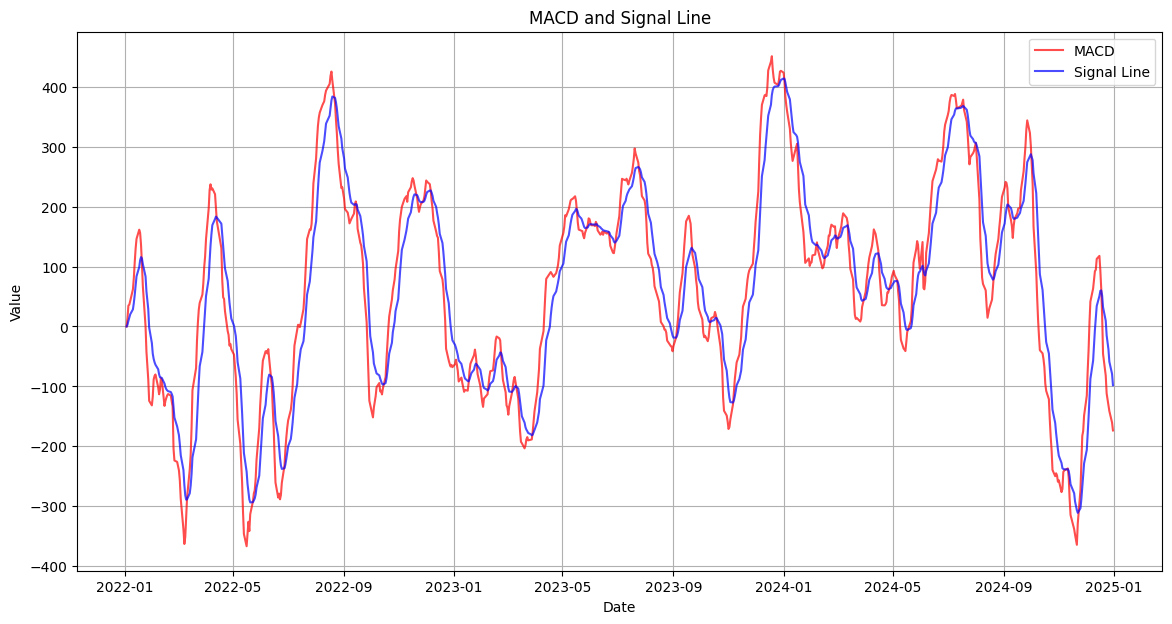

In [112]:
# Plot MACD and Signal Line
plt.figure(figsize=(14, 7))
plt.plot(data_cleaned['Date'], data_cleaned['MACD'], label='MACD', color='red', alpha=0.7)
plt.plot(data_cleaned['Date'], data_cleaned['Signal_Line'], label='Signal Line', color='blue', alpha=0.7)
plt.title('MACD and Signal Line')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.show()

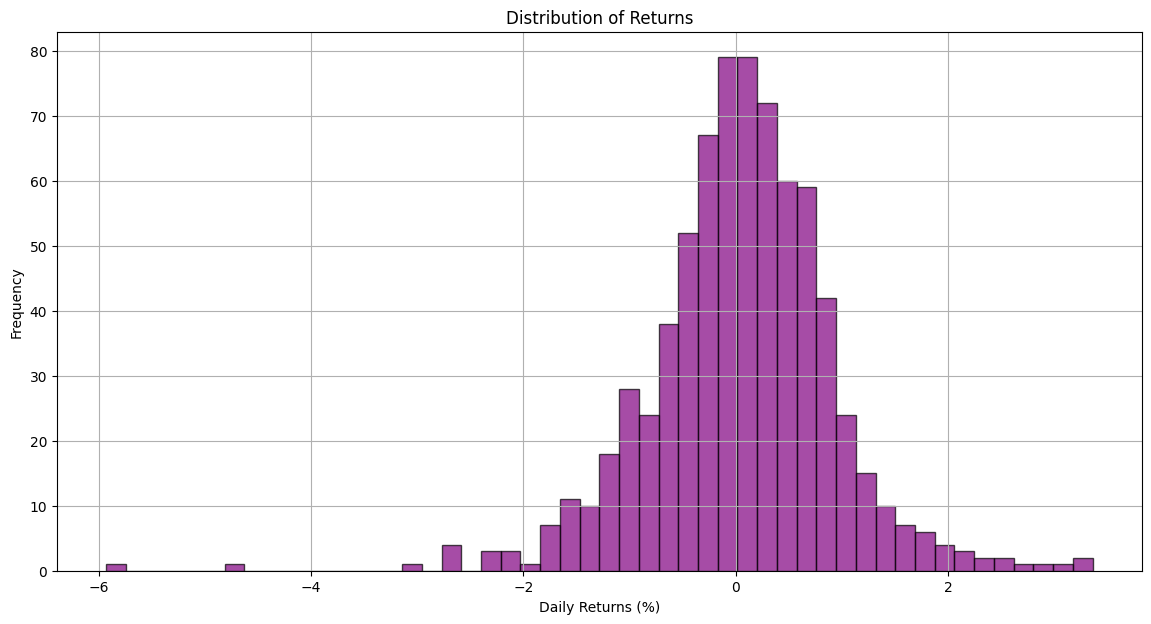

In [113]:
# Distribution of Returns
data_cleaned['Returns'] = data_cleaned['Close'].pct_change() * 100
plt.figure(figsize=(14, 7))
plt.hist(data_cleaned['Returns'].dropna(), bins=50, alpha=0.7, color='purple', edgecolor='black')
plt.title('Distribution of Returns')
plt.xlabel('Daily Returns (%)')
plt.ylabel('Frequency')
plt.grid()

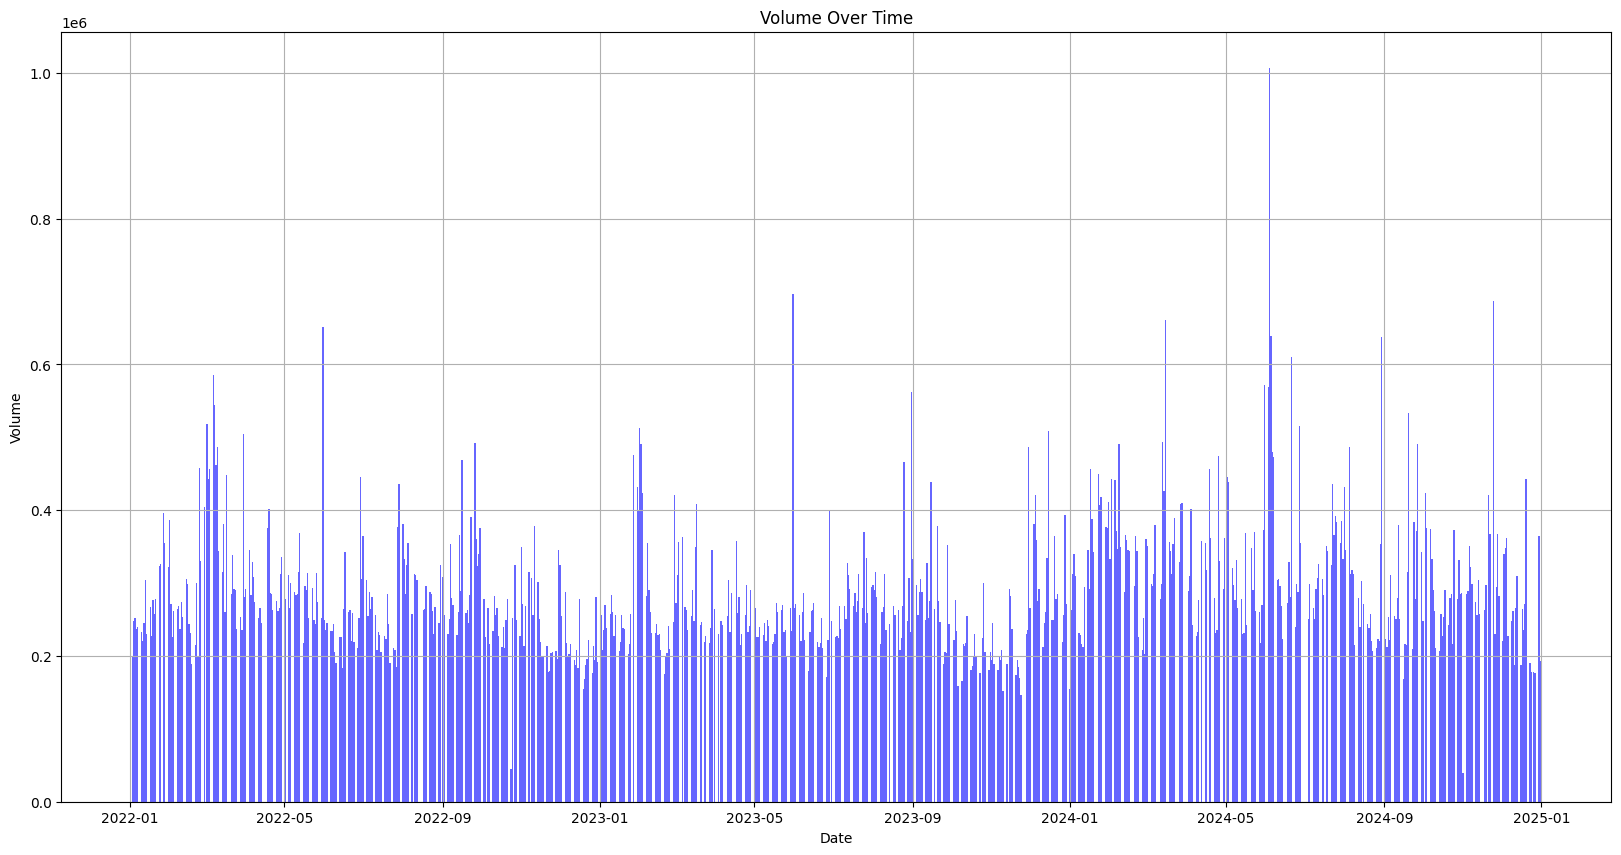

In [114]:
# Volume over time
plt.figure(figsize=(20, 10))
plt.bar(data_cleaned['Date'], data_cleaned['Volume'], color='Blue', alpha=0.6, width=1.0)
plt.title('Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.grid()
plt.show()

In [115]:
#Train-Test Split
features = ['Close', 'MA_20', 'MA_50', 'RSI', 'MACD', 'Signal_Line']
X = data_cleaned[features]
y = data_cleaned['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [116]:
print(f"Missing values in X_train before handling: \n{pd.DataFrame(X_train).isnull().sum()}")

Missing values in X_train before handling: 
Close           0
MA_20          16
MA_50          41
RSI            10
MACD            0
Signal_Line     0
dtype: int64


In [117]:
from sklearn.impute import SimpleImputer

# Impute missing values with the mean for numeric columns
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)


In [118]:

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

In [119]:
results = []
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

    # Evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob) if y_prob is not None else None

    # Append results
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc
    })

    # Print metrics
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-Score: {f1:.2f}")
    if roc_auc is not None:
        print(f"ROC-AUC: {roc_auc:.2f}")


Training Logistic Regression...
Accuracy: 0.53
Precision: 0.54
Recall: 0.76
F1-Score: 0.64
ROC-AUC: 0.51

Training Random Forest...
Accuracy: 0.61
Precision: 0.62
Recall: 0.69
F1-Score: 0.65
ROC-AUC: 0.60

Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:46:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.58
Precision: 0.60
Recall: 0.66
F1-Score: 0.63
ROC-AUC: 0.58


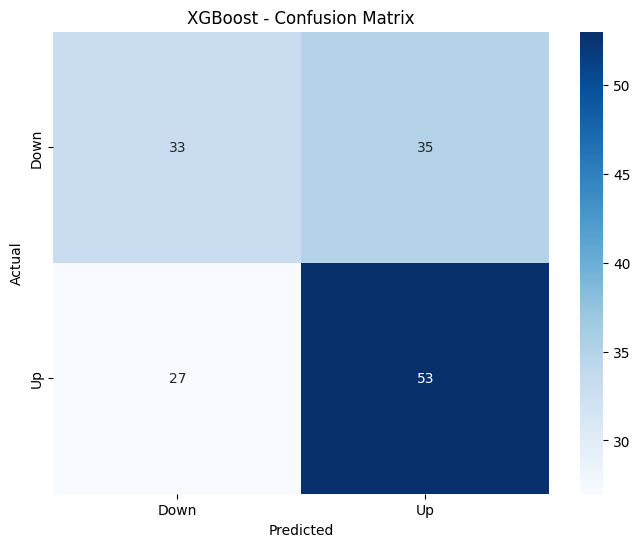

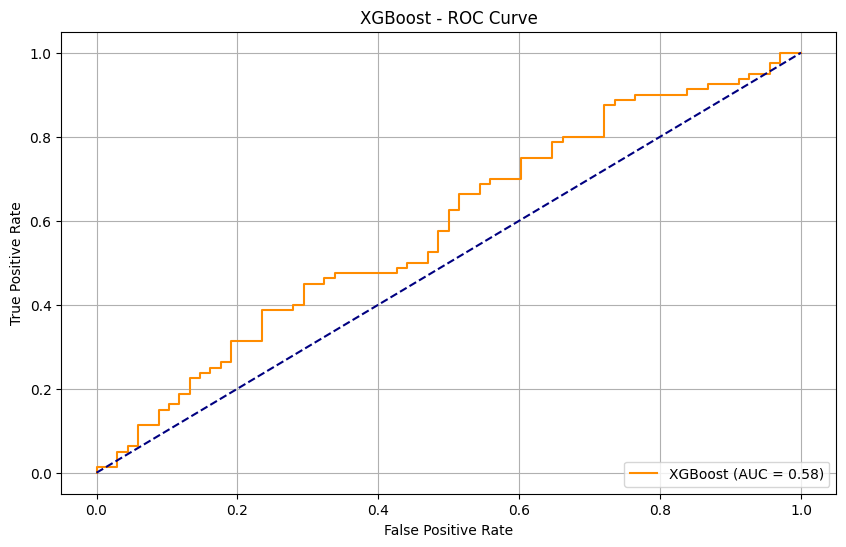


Model Comparison:
                 Model  Accuracy  Precision  Recall  F1-Score   ROC-AUC
0  Logistic Regression  0.527027   0.544643  0.7625  0.635417  0.509007
1        Random Forest  0.608108   0.625000  0.6875  0.654762  0.595772
2              XGBoost  0.581081   0.602273  0.6625  0.630952  0.583456


In [120]:
    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Down', 'Up'], yticklabels=['Down', 'Up'])
    plt.title(f'{name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # ROC Curve
    if y_prob is not None:
        fpr, tpr, thresholds = roc_curve(y_test, y_prob)
        plt.figure(figsize=(10, 6))
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})', color='darkorange')
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
        plt.title(f'{name} - ROC Curve')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc='lower right')
        plt.grid()
        plt.show()

# Display results
results_df = pd.DataFrame(results)
print("\nModel Comparison:")
print(results_df)



In [121]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Simulated Historical Data
np.random.seed(42)
dates = pd.date_range(start="2023-01-01", periods=200)
data = pd.DataFrame({
    'Date': dates,
    'Close': np.random.uniform(100, 200, size=len(dates))
})
data['Price_Change'] = data['Close'].pct_change()  # Daily percentage change
data['Target'] = (data['Price_Change'] > 0).astype(int)  # Binary target: 1 for up, 0 for down
data = data.dropna()

# Predictions (Replace with Task 2 model predictions)
data['Predictions'] = np.random.choice([0, 1], size=len(data), p=[0.5, 0.5])

# Parameters for Backtesting
transaction_cost = 0.001  # 0.1%
slippage = 0.001  # 0.1%
initial_capital = 100000

# Initialize variables
capital = initial_capital
positions = 0
cumulative_returns = [capital]

# Ensure the DataFrame index is reset to default integer indexing
data.reset_index(drop=True, inplace=True)

# Backtesting Logic
for i in range(1, len(data)):
    current_price = data.iloc[i]['Close']
    prev_price = data.iloc[i - 1]['Close']
    prediction = data.iloc[i - 1]['Predictions']

    # Buy signal
    if prediction == 1 and positions == 0:
        positions = capital / current_price
        capital -= positions * current_price * (1 + transaction_cost + slippage)

    # Sell signal
    elif prediction == 0 and positions > 0:
        capital += positions * current_price * (1 - transaction_cost - slippage)
        positions = 0

    # Portfolio value
    portfolio_value = capital + positions * current_price
    cumulative_returns.append(portfolio_value)

# Buy-and-Hold Strategy
buy_and_hold_initial = initial_capital / data['Close'].iloc[0]
buy_and_hold_returns = buy_and_hold_initial * data['Close']

# Performance Metrics
cumulative_returns = np.array(cumulative_returns)



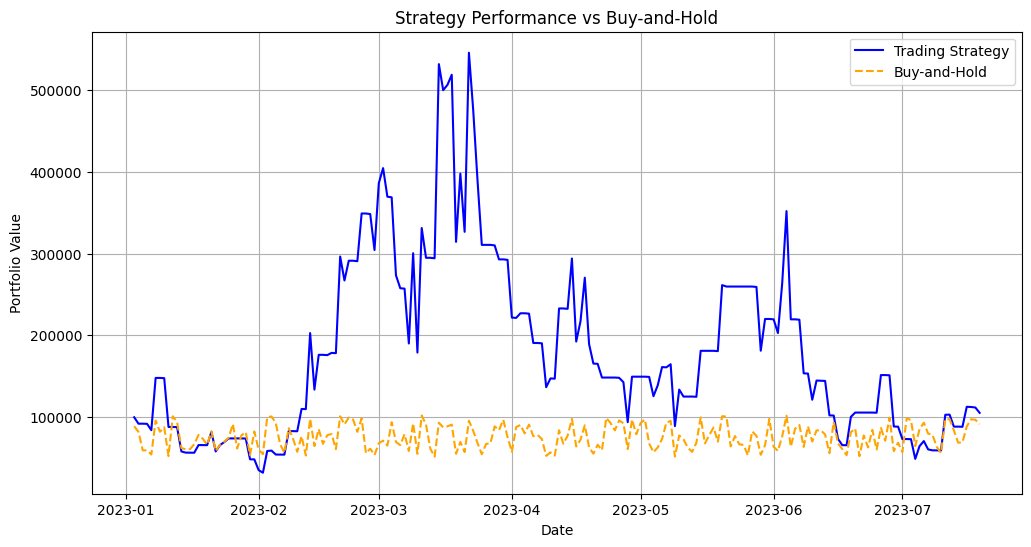


Trading Strategy Performance Metrics:
Cumulative Returns: 5.18%
Sharpe Ratio: 1.68
Maximum Drawdown: -91.05%
Final Portfolio Value: 105178.11


In [122]:
cumulative_returns = np.array(cumulative_returns)
daily_returns = pd.Series(cumulative_returns).pct_change().dropna()
sharpe_ratio = np.sqrt(252) * daily_returns.mean() / daily_returns.std()  # Annualized Sharpe Ratio
maximum_drawdown = (cumulative_returns / np.maximum.accumulate(cumulative_returns)).min() - 1

# Adjust 'Date' to match the length of 'cumulative_returns[1:]'
dates_for_plot = data['Date'].iloc[1:]

# Plot Strategy Performance
plt.figure(figsize=(12, 6))
plt.plot(dates_for_plot, cumulative_returns[1:], label='Trading Strategy', color='blue')
plt.plot(dates_for_plot, buy_and_hold_returns.iloc[1:], label='Buy-and-Hold', color='orange', linestyle='--')
plt.title('Strategy Performance vs Buy-and-Hold')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.grid(True)
plt.show()


# Display Performance Metrics
print("\nTrading Strategy Performance Metrics:")
print(f"Cumulative Returns: {cumulative_returns[-1] / initial_capital - 1:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Maximum Drawdown: {maximum_drawdown:.2%}")
print(f"Final Portfolio Value: {portfolio_value:.2f}")


In [123]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Initialize the model
rf_model = RandomForestClassifier(random_state=42)

# Grid search
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model
best_rf_model = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)

# Evaluate the optimized model
y_pred_optimized = best_rf_model.predict(X_test)
print("Optimized Model Accuracy:", accuracy_score(y_test, y_pred_optimized))


Best parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Optimized Model Accuracy: 0.6013513513513513


In [125]:
## I am taking only 1 lot at a time for buying or selling
# Parameters for strategy refinement
stop_loss_pct = 0.02  # 2%
take_profit_pct = 0.05  # 5%

# Initialize variables
initial_capital = 100000  # Example starting capital
transaction_cost = 0.001  # 0.1% per trade
slippage = 0.001  # 0.1% slippage

capital = initial_capital
positions = 0
entry_price = 0
cumulative_returns = [capital]

# Backtesting Logic with Stop-loss and Take-profit
for i in range(1, len(data)):
    current_price = data.loc[i, 'Close']
    prediction = data.loc[i - 1, 'Predictions']
    # print("these below are the current and capital")
    # print(current_price)
    # print(capital)

    # Buy signal
    if prediction == 1 and positions == 0:
        positions = capital / current_price
        entry_price = current_price
        # capital -= positions * current_price * (1 + transaction_cost + slippage)
        capital += current_price * (1 - transaction_cost - slippage)
        print(f"Buy: Entered at {entry_price:.2f}, Current Capital: {capital:.2f}")

    # Sell signal or risk management (Stop-loss or Take-profit)
    elif positions > 0:
        if prediction == 0 or current_price <= entry_price * (1 - stop_loss_pct) or current_price >= entry_price * (1 + take_profit_pct):
            capital += current_price * (1 - transaction_cost - slippage)
            print(f"Sell: Exited at {current_price:.2f}, Current Capital: {capital:.2f}")
            positions = 0

    # Portfolio value
    portfolio_value = capital + current_price
    cumulative_returns.append(portfolio_value)

# Final Portfolio Liquidation (if holding a position)
if positions > 0:
    capital += current_price * (1 - transaction_cost - slippage)
    print(f"Final Liquidation: Sold remaining position at {current_price:.2f}, Final Capital: {capital:.2f}")
    positions = 0
    portfolio_value = capital

# Evaluate Performance Metrics
cumulative_returns = pd.Series(cumulative_returns)
max_drawdown = (cumulative_returns / cumulative_returns.cummax() - 1).min()
sharpe_ratio = (cumulative_returns.pct_change().mean() / cumulative_returns.pct_change().std()) * np.sqrt(252)

# Print Performance Metrics
print("\n--- Strategy Performance ---")
print(f"Final Portfolio Value: {portfolio_value:.2f}")
print(f"Maximum Drawdown: {max_drawdown:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Cumulative Returns: {cumulative_returns.tolist()}")


Buy: Entered at 173.20, Current Capital: 100172.85
Sell: Exited at 159.87, Current Capital: 100332.40
Buy: Entered at 115.60, Current Capital: 100447.77
Sell: Exited at 105.81, Current Capital: 100553.36
Buy: Entered at 170.81, Current Capital: 100723.83
Sell: Exited at 102.06, Current Capital: 100825.68
Buy: Entered at 183.24, Current Capital: 101008.56
Sell: Exited at 121.23, Current Capital: 101129.55
Buy: Entered at 118.18, Current Capital: 101247.50
Sell: Exited at 118.34, Current Capital: 101365.60
Buy: Entered at 130.42, Current Capital: 101495.77
Sell: Exited at 152.48, Current Capital: 101647.94
Buy: Entered at 129.12, Current Capital: 101776.80
Sell: Exited at 161.19, Current Capital: 101937.66
Buy: Entered at 113.95, Current Capital: 102051.39
Sell: Exited at 129.21, Current Capital: 102180.34
Buy: Entered at 136.64, Current Capital: 102316.71
Sell: Exited at 145.61, Current Capital: 102462.02
Buy: Entered at 159.24, Current Capital: 102620.94
Sell: Exited at 104.65, Current